In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import warnings
import seaborn as sns
import time
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer


from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier



In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

full = pd.concat([train,test])

## Feature Exploration

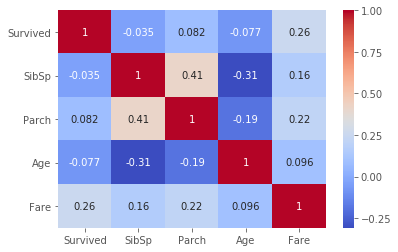

In [3]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot = True,cmap = "coolwarm")

- Fare

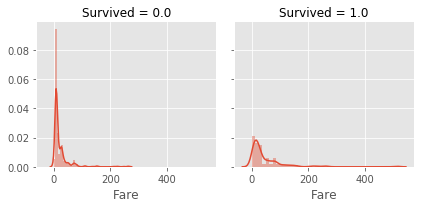

In [4]:
g = sns.FacetGrid(data = full,col = "Survived")
g.map(sns.distplot, "Fare")

Apply $log_10$ to Fare to reduce skewness

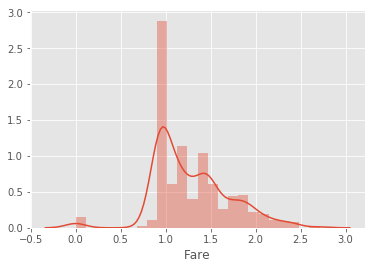

In [5]:
g = sns.distplot(train["Fare"].apply(lambda x: math.log10(x+1)),label = "Skewness : %.2f"%(full["Fare"].skew()))

- Age

In [6]:
pd.cut(train[train.Survived==1.0].Age,20).value_counts().sort_index()

(0.34, 4.399]       27
(4.399, 8.378]       9
(8.378, 12.357]      4
(12.357, 16.336]    15
(16.336, 20.315]    27
(20.315, 24.294]    36
(24.294, 28.273]    30
(28.273, 32.252]    35
(32.252, 36.231]    35
(36.231, 40.21]     17
(40.21, 44.189]     12
(44.189, 48.168]    12
(48.168, 52.147]    14
(52.147, 56.126]     7
(56.126, 60.105]     5
(60.105, 64.084]     4
(64.084, 68.063]     0
(68.063, 72.042]     0
(72.042, 76.021]     0
(76.021, 80.0]       1
Name: Age, dtype: int64

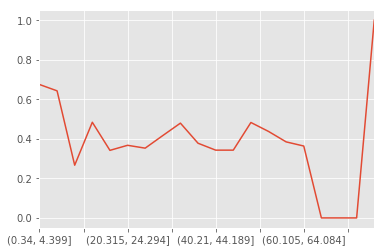

In [7]:
(pd.cut(train[train.Survived==1.0].Age,20).value_counts().sort_index()/pd.cut(train.Age,20).value_counts().sort_index()).plot()

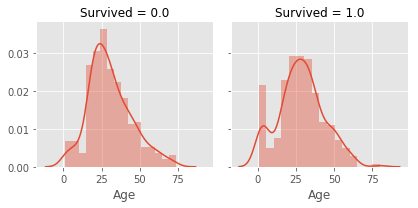

In [8]:
g = sns.FacetGrid(data = full,col = "Survived")
g.map(sns.distplot, "Age")

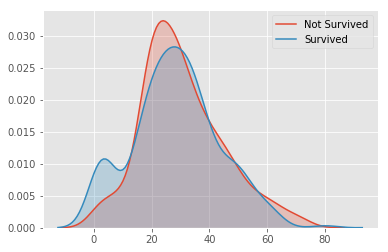

In [9]:
g = sns.kdeplot(train[train["Survived"] == 0]["Age"],shade = True)
g = sns.kdeplot(train[train["Survived"] == 1]["Age"], shade = True)
g.legend(["Not Survived","Survived"])

- SibSp

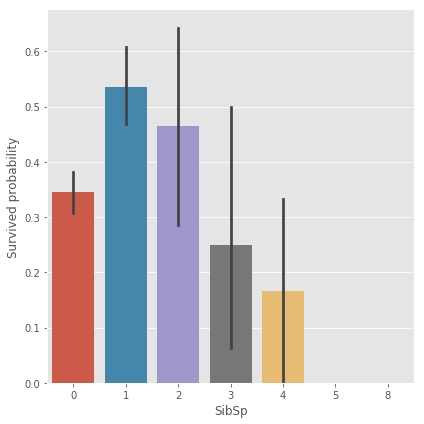

In [10]:
g = sns.factorplot("SibSp","Survived",data = train,kind = "bar",size = 6)
g.set_ylabels("Survived probability")

- Parch

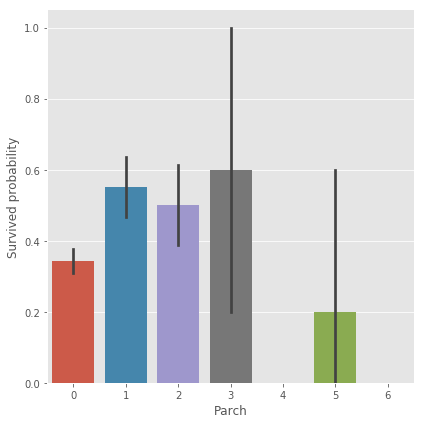

In [11]:
g = sns.factorplot("Parch","Survived",data = train, kind = "bar", size = 6)
g.set_ylabels("Survived probability")

- Sex

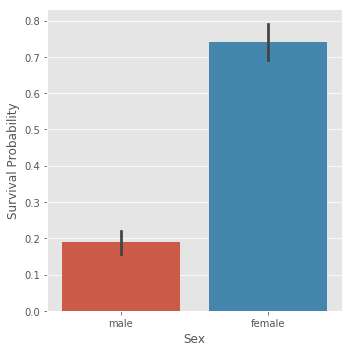

In [12]:
g = sns.factorplot("Sex","Survived",data = train, kind = "bar")
g.set_ylabels("Survival Probability")

In [13]:
train[["Sex","Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.742038
male,0.188908


- Pclass

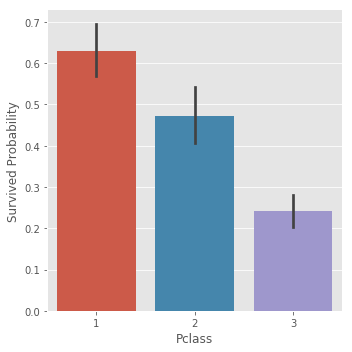

In [14]:
g = sns.factorplot("Pclass","Survived", data = train, kind = "bar")
g.set_ylabels("Survived Probability")

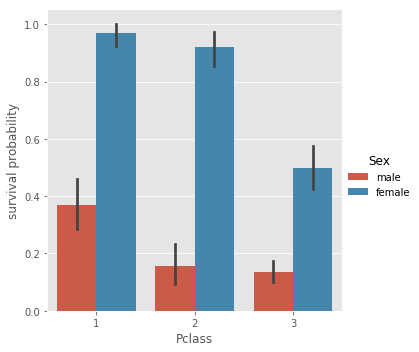

In [15]:
g = sns.factorplot("Pclass","Survived", data = train, hue = "Sex", kind = "bar")
g = g.set_ylabels("survival probability")

## Missing Values

- Age

In [16]:
train.corr()["Age"].sort_values(ascending = True)

Pclass        -0.369226
SibSp         -0.308247
Parch         -0.189119
Survived      -0.077221
PassengerId    0.036847
Fare           0.096067
Age            1.000000
Name: Age, dtype: float64

The correlation matrix shows that Sex is related with $Pclass$,$Sibsp$, $Parch$.

In [17]:
full["Age"] = full.groupby(["Pclass","SibSp"]).Age.transform(lambda x:x.fillna(x.median()))

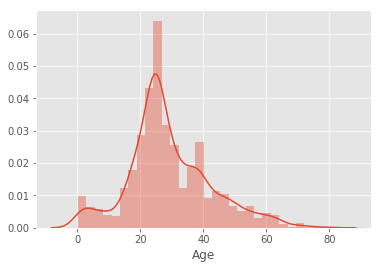

In [18]:
g = sns.distplot(full["Age"])

- Embarked

In [19]:
full.Embarked = full.Embarked.fillna('S')

- Fare

In [20]:
full["Fare"] = full.Fare.fillna(full.Fare.median())

## Feature Engineering

- Title/Name

In [21]:
def parse(name):
    name = name.split(',')
    title = name[1].split('.')
    title = title[0].strip()
    if title in ["Jonkheer","Don", "Sir", "the Countess","Dona","Lady"]:
        return 'Loyalty'
    elif title in ["Capt","Col","Major","Dr","Rev"]:
        return "Officer"
    elif title in ["Mme","Ms"]:
        return "Mrs"
    elif title in ["Mlle"]:
        return "Miss"
    else:
        return title


In [22]:
full["Name"] = full.Name.map(parse)

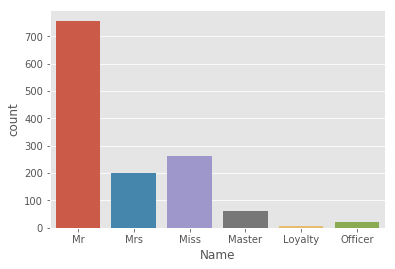

In [23]:
g = sns.countplot(full["Name"])

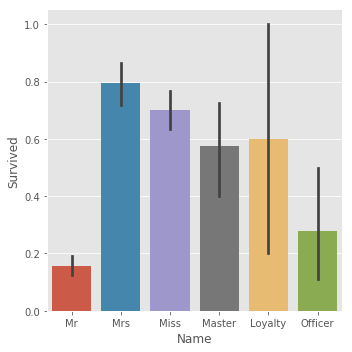

In [24]:
g = sns.catplot("Name","Survived", data = full, kind = "bar")

- Cabin

In [25]:
full["Cabin"] = full["Cabin"].fillna("X")

In [26]:
full["Cabin"] = full["Cabin"].apply(lambda x:x[0])

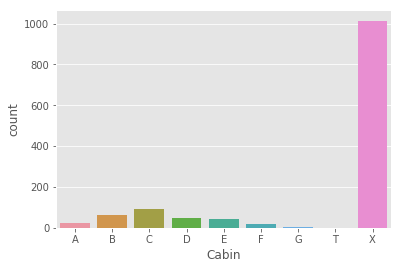

In [27]:
g = sns.countplot(full["Cabin"].apply(lambda x:x[0]), order = list("ABCDEFGTX"))

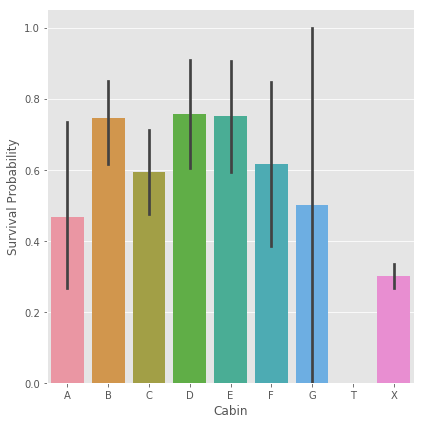

In [28]:
g = sns.catplot("Cabin","Survived", data = full, kind = "bar", size = 6, order = list("ABCDEFGTX"))
g.set_ylabels("Survival Probability")

- Ticket

In [29]:
full["Ticket"] = full["Ticket"].apply(lambda x: x.replace(".","").replace("/","").split(' ')[0] if not x.isdigit() else "X")

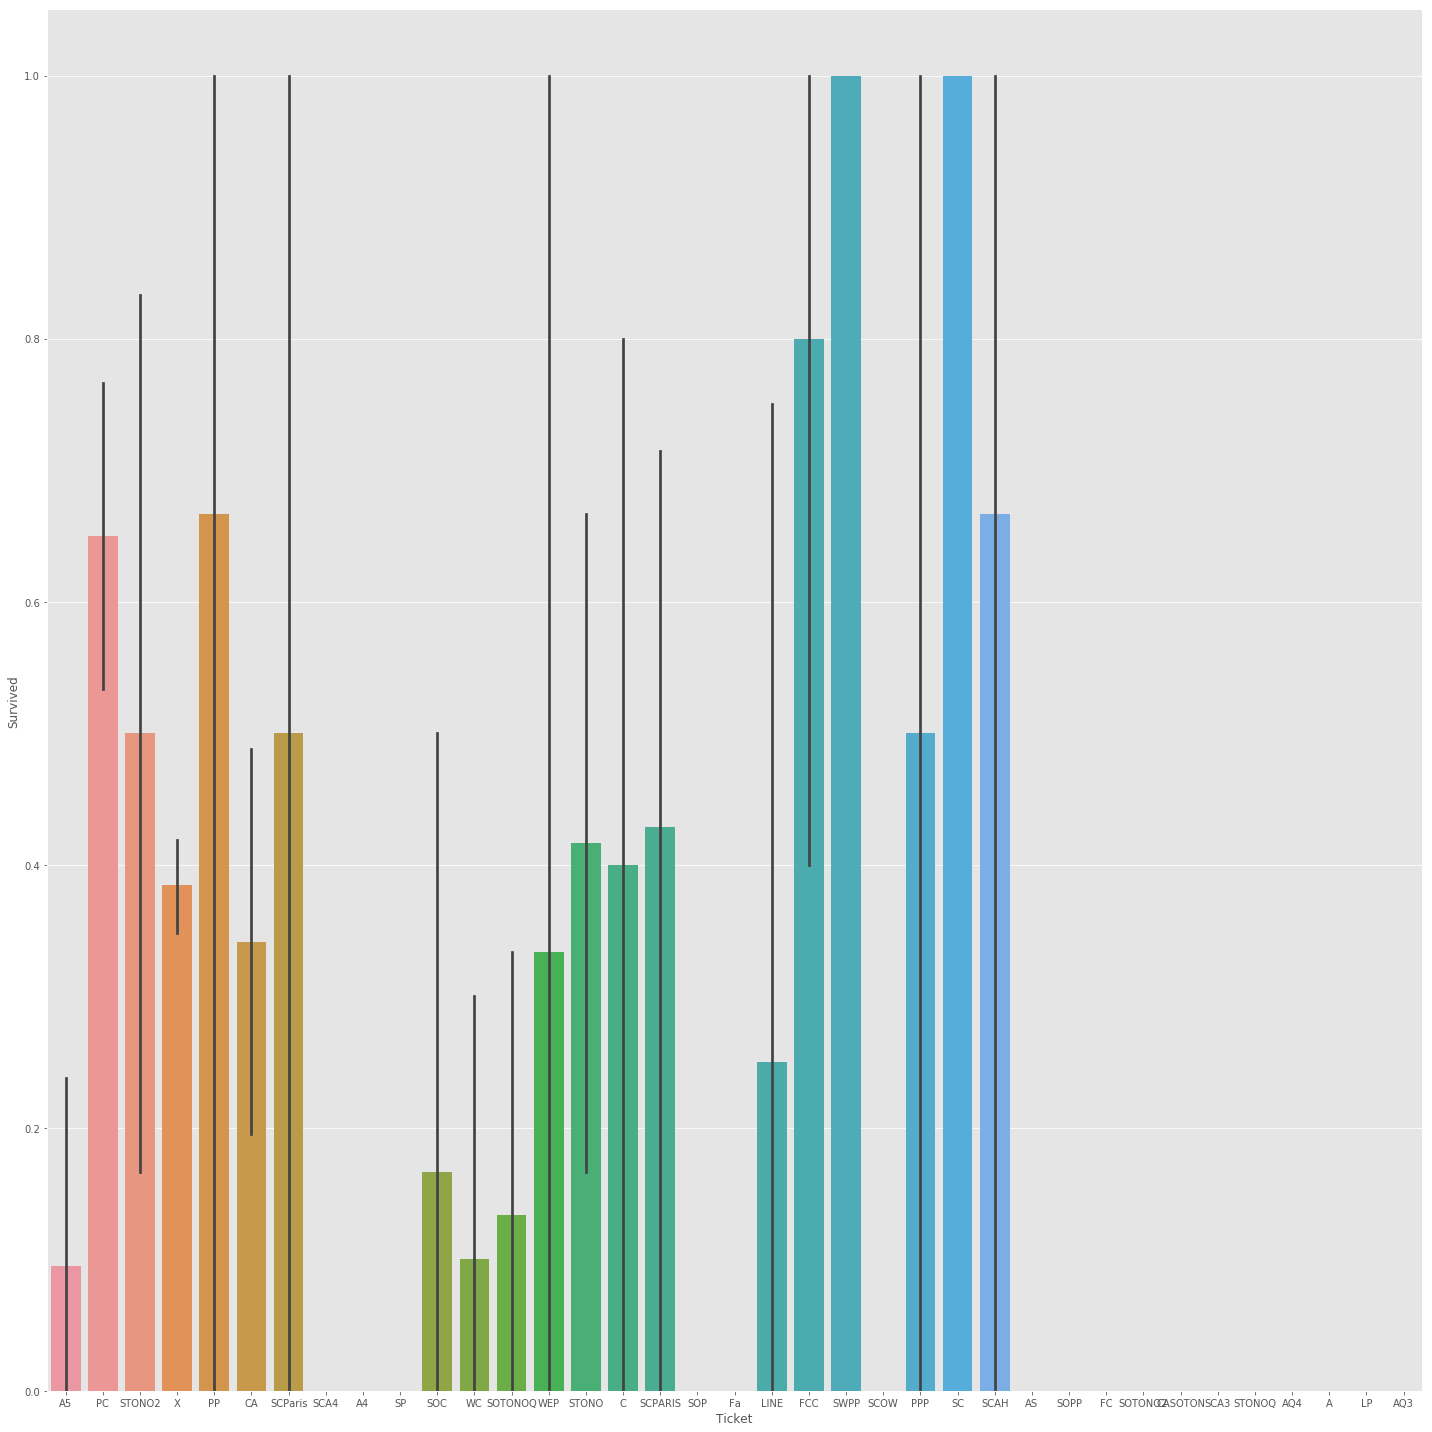

In [30]:
g = sns.catplot("Ticket", "Survived", data = full, kind = "bar",size = 20)

In [31]:
def ifkid(age):
    if age < 8:
        return 1
    else:
        return 0
kid = pd.DataFrame({"Kid":full.Age.map(ifkid)})
full = pd.concat([full,kid],axis = 1)

- Parch

In [32]:
full.Parch.sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 9])

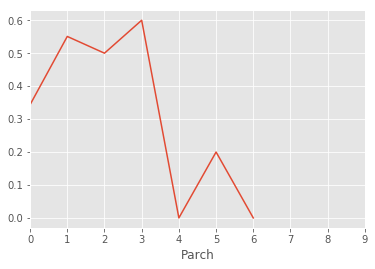

In [33]:
(full.groupby(["Parch"]).sum().Survived/full.groupby(["Parch"]).count().Survived).plot.line()

In [34]:
full.SibSp.sort_values().unique()

array([0, 1, 2, 3, 4, 5, 8])

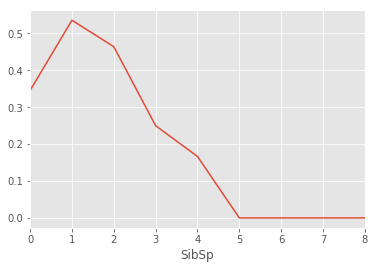

In [35]:
(full.groupby(["SibSp"]).sum().Survived/full.groupby(["SibSp"]).count().Survived).plot.line()

In [36]:
def map_values():
    full["Sex"] = full.Sex.map({"male":1,"female":0})
    full["Parch"] = full.Parch.map({0:1,
                             1:0,2:0,3:0,
                             4:2,5:2,6:2,9:2})
    full["SibSp"] = full.SibSp.map({0:0,1:0,2:0,
                             3:1,4:1,
                             5:2,8:2})

In [37]:
map_values()

In [38]:
full = full.drop("Survived", axis = 1)
full = full.drop("PassengerId", axis = 1)

## Pipeline

In [39]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [40]:
pipe = Pipeline([
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [41]:
full2 = full.copy()

In [42]:
data_pipe = pipe.fit_transform(full2)

In [43]:
data_pipe.shape

(1309, 62)

## Split training and test data

In [44]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.Survived


## Feature combination

In [45]:
logit = LogisticRegression()
logit.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

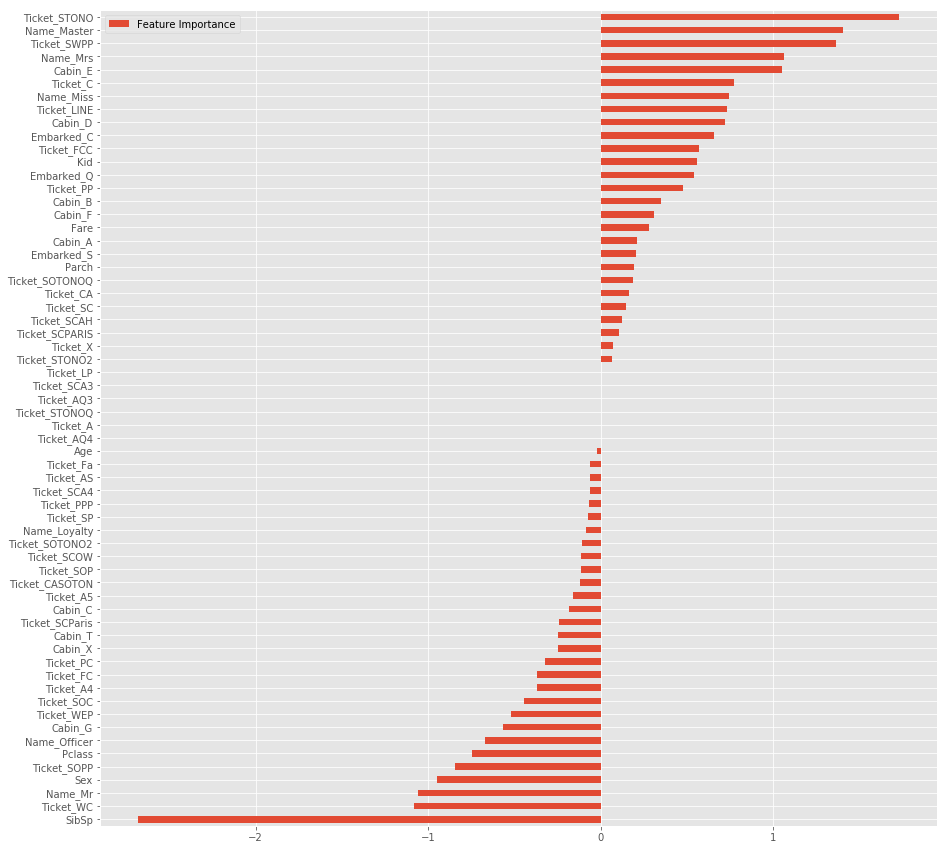

In [46]:
FI_logit = pd.DataFrame(data = {"Feature Importance":logit.coef_[0]},index = data_pipe.columns)
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
FI_logit.sort_values("Feature Importance", ascending = True).plot(kind = "barh",ax=ax)

In [33]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
  
        X["Miss+Embarked_C"] = X["Name_Miss"] + X["Embarked_C"]
        X["Miss+Embarked_Q"] = X["Name_Miss"] + X["Embarked_Q"]
            
        X["Mrs+Embarked_C"] = X["Name_Mrs"] + X["Embarked_C"]
        X["Kid+Embarked_C"] = X["Kid"] + X["Embarked_C"]
        X["Parch+SibSp"] = X["Parch"] + X["SibSp"]
        X["Pclass+Sex"] = X["Pclass"] + X["Sex"]
#         X["-Pclass+Kid"] = - X["Pclass"] + X["Kid"]
        X["Pclass-Embarked_c"] = X["Pclass"] + X["Embarked_C"]
        X["SibSp+Sex"] = X["SibSp"] + X["Sex"]
        
    
        return X

In [34]:
pipe = Pipeline([
    ('skew_dummies1', skew_dummies(skew=1)),
    ('add_feature', add_feature()),
    ('skew_dummies2', skew_dummies(skew=1)),
    ])

In [35]:
full_pipe = pipe.fit_transform(full)

## Modeling

In [54]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.Survived

In [55]:
print("X.shape :", X.shape); print("y.shape :", y.shape)

X.shape : (891, 62)
y.shape : (891,)


In [56]:
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
# classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
# classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier(n_neighbors=20))
classifiers.append(LogisticRegression(random_state = random_state))
# classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y, scoring = "accuracy", cv = 10, n_jobs=-1))

In [57]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

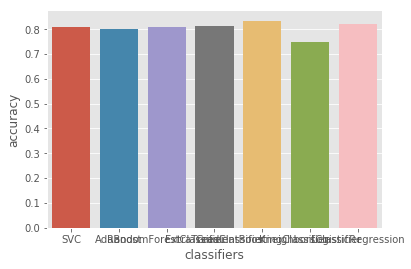

In [58]:
cv_res = pd.DataFrame({"classifiers":classifiers,"accuracy": cv_means})
cv_res["classifiers"] = ["SVC","AdaBoost","RandomForestClassifier","ExtraTreesClassifier",
                         "GradientBoostingClassifier","KneighborsClassifier","LogisticRegression"]
g = sns.barplot("classifiers","accuracy", data = cv_res)

### RandomForestClassifier

In [59]:
start = time.time()
randomforest = RandomForestClassifier(n_estimators=300)
randomforest.fit(X,y)
print(time.time()-start)

0.41797804832458496


In [60]:
param_rfc_0 = {'n_estimators':range(200,301,10)}
rbc = GridSearchCV(estimator = RandomForestClassifier(min_samples_leaf= 100,
                                                           random_state= 42), 
                        param_grid = param_rfc_0, scoring='accuracy', iid=False, cv=10)
rbc.fit(X,y)
rbc.best_params_, rbc.best_score_

({'n_estimators': 240}, 0.7599060833049597)

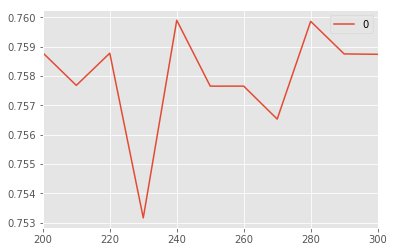

In [61]:
pd.DataFrame(rbc.cv_results_["mean_test_score"],index=range(200,301,10)).plot()

In [62]:
rf_param_grid = {"max_depth": [None],
              "max_features": range(1,11,2),
              "min_samples_split": [2,3,10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[240],
              "criterion": ["gini","entropy"]}

gsRFC = GridSearchCV(estimator=RandomForestClassifier(),param_grid = rf_param_grid, 
                     cv=5, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X,y)

RFC_best = gsRFC.best_estimator_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   35.4s finished


In [73]:
gsRFC.best_params_, gsRFC.best_score_

({'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 9,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 240},
 0.8316498316498316)

## GradientBoostingDecisionTree

In [74]:
start = time.time()
randomforest = GradientBoostingClassifier(n_estimators=300)
randomforest.fit(X,y)
print(time.time()-start)

0.364213228225708


In [75]:
param_gbdt_0 = {'n_estimators':range(10,201,10)}
gbdt_0 = GridSearchCV(estimator = GradientBoostingClassifier(min_samples_leaf= 100,
                                                           random_state= 42), 
                        param_grid = param_gbdt_0, scoring='accuracy', iid=False, cv=10)
gbdt_0.fit(X,y)
gbdt_0.best_params_, gbdt_0.best_score_

({'n_estimators': 80}, 0.8306077630234935)

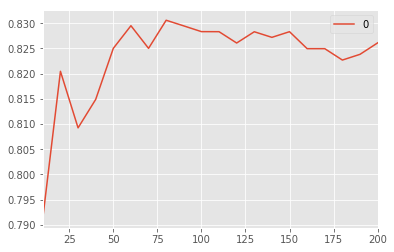

In [76]:
pd.DataFrame(gbdt_0.cv_results_["mean_test_score"],index=range(10,201,10)).plot()

In [77]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [80,90,100],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': range(3,14,2),
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X,y)

GBC_best = gsGBC.best_estimator_


gsGBC.best_score_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 1744 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed:   29.5s finished


0.8260381593714927

## AdaBoost

In [68]:
param_ada_0 = {'n_estimators':range(100,201,10)}
ada_0 = GridSearchCV(estimator = AdaBoostClassifier(), 
                        param_grid = param_ada_0, scoring='accuracy', iid=False, cv=10)
ada_0.fit(X,y)
ada_0.best_params_, ada_0.best_score_

({'n_estimators': 150}, 0.809334354783793)

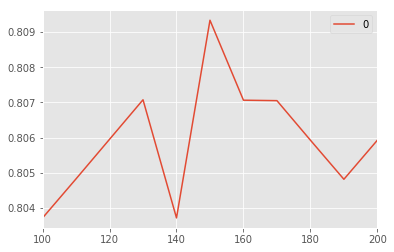

In [70]:
pd.DataFrame(ada_0.cv_results_["mean_test_score"],index=range(100,201,10)).plot()

In [72]:

ada_param_grid = {
              'n_estimators' : [140,150,160],
              'learning_rate': [0.1, 0.05, 0.01],
              }

gsADA = GridSearchCV(estimator=AdaBoostClassifier(),param_grid = ada_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)

gsADA.fit(X,y)

ADA_best = gsADA.best_estimator_


gsADA.best_score_, gsADA.best_params_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    6.8s finished


(0.8249158249158249, {'learning_rate': 0.1, 'n_estimators': 150})

## XgBoost

In [79]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:

gb_param_grid = {
              
              'learning_rate': [0.1, 0.05, 0.01],
              'gamma': [0.01,0.05,0.1],
              
              'max_depth': range(2,15,3) 
              }

gsXGB = GridSearchCV(estimator=XGBClassifier(),param_grid = gb_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)

gsXGB.fit(X,y)

XGB_best = gsGBC.best_estimator_


gsXGB.best_score_, gsXGB.best_params_

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 217 tasks      | elapsed:   20.2s


In [71]:
submission = pd.DataFrame({"PassengerId":test.PassengerId,"Survived":pred})
submission.to_csv("submission.csv", index = False)

## SVC

In [63]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=10, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X,y)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_,gsSVMC.best_params_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   27.1s finished


(0.8372615039281706, {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'})

## KNeighbor

In [65]:
param_kn_0 = {'n_neighbors':range(5,101,5),
              "algorithm":['auto','ball_tree', 'kd_tree', 'brute']}
kn_0 = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid = param_kn_0, scoring='accuracy', iid=False, cv=10)
kn_0.fit(X,y)
kn_0.best_params_, kn_0.best_score_

({'algorithm': 'auto', 'n_neighbors': 5}, 0.7957879355351266)

## Ensemble modeling

- #### Voting models

In [78]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), 
#                                        ('extc', ExtC_best),
                                       ('svc', SVMC_best), 
                                       ('adac',ADA_best),
                                       ('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X, y)

In [52]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [58]:
stack_model = stacking(mod=[kn_0,svc_0,gsearch2],meta_model=gbdt_3)

In [61]:
a = Imputer().fit_transform(X)
b = Imputer().fit_transform(y.values.reshape(-1,1)).ravel()

In [83]:
stack_model.fit(a,b)

NameError: name 'stack_model' is not defined

## Prediction

In [79]:
pred = votingC.predict(test_X)

In [74]:
stack_model.score(a,b)

0.3925798101811906

In [81]:
submission = pd.DataFrame({"PassengerId":test.PassengerId,"Survived":pred})
submission["Survived"] = submission.Survived.map(int)
submission.to_csv("submission.csv", index = False)